In [2]:
#This notebook is geared towards making movies of seconds timescale data
#that visualizes when PMTs are firing in coincidence with charge events. 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime
import glob
import pickle
from datetime import datetime, timedelta
import sys
from scipy.optimize import curve_fit

from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

#import the folder that has the analysis level class
sys.path.append("../CombinedData/")
sys.path.append("../AnalysisTools/")
import AnalysisTools

In [4]:

topdir = "../../data/"
config = "../configs/run9_config.yaml"
title = "MgF2 (20nm)"
red_file_name = "combined_reduced.p"
#analysis tools objects, unloaded data
ana = AnalysisTools.AnalysisTools(topdir+red_file_name, config, title=title, ramp_topdir=topdir)



In [6]:

d = ana.df
d = d[~d["ch3 charge"].isna()]
#select charge event mask for which to qualify coincidences with
mask = (d["ch3 n negpeaks"] > 0) & (d["ch3 n pospeaks"] == 0) & (np.abs(d["ch3 charge"]) > 1)

d = d[mask]

#coincidence info
time_ref_ch = 3 #software channel for which to look for coincidences of
coinc = 5 #long coincidence window in seconds, sets the length of a movie observing these events. 
coinc_ns = 0
event_dfs = ana.get_coincidence(d, time_ref_ch, coinc, coinc_ns)


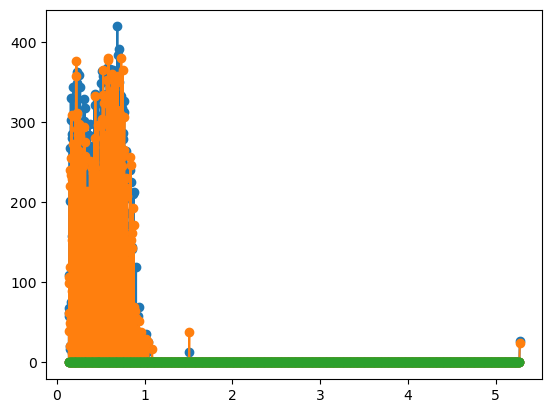

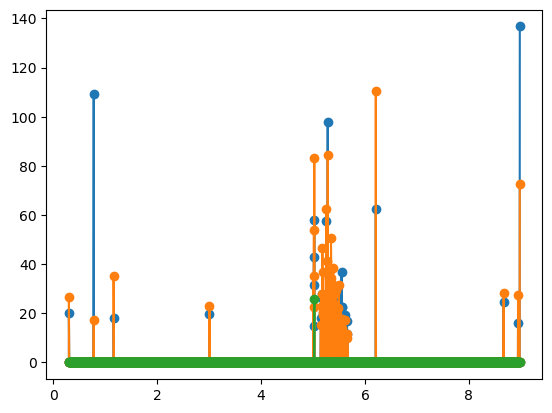

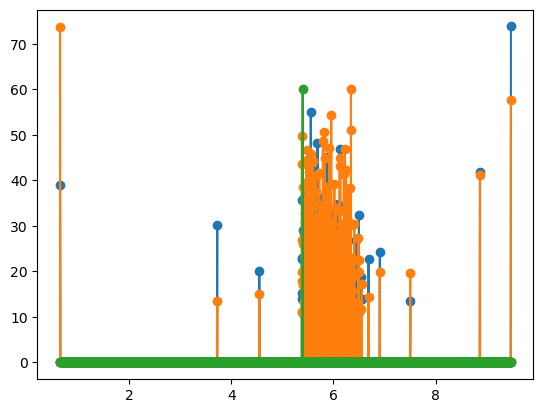

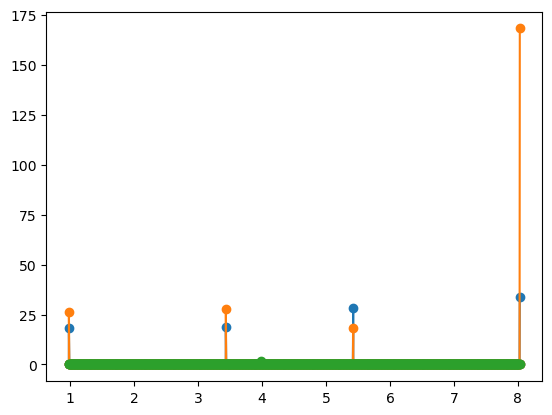

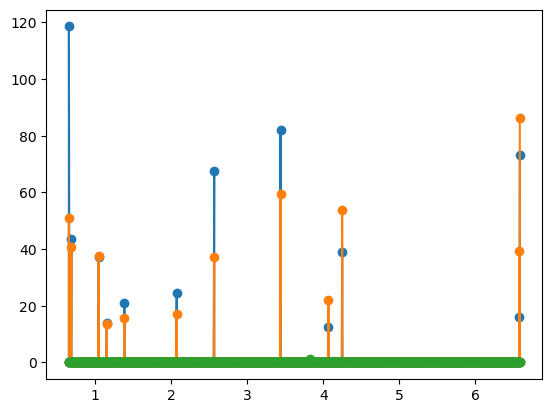

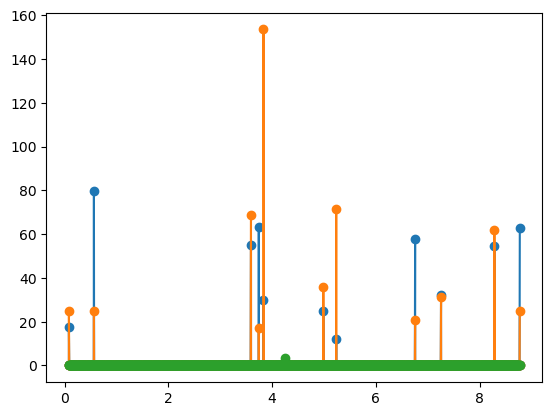

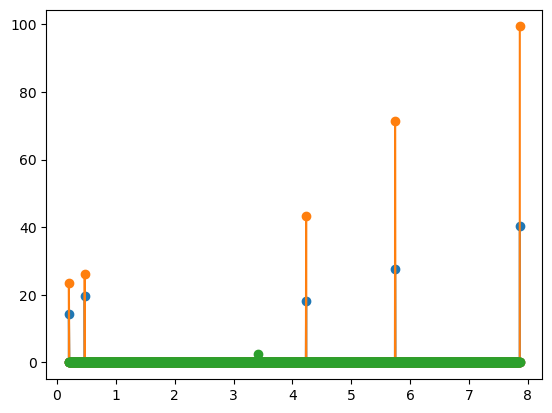

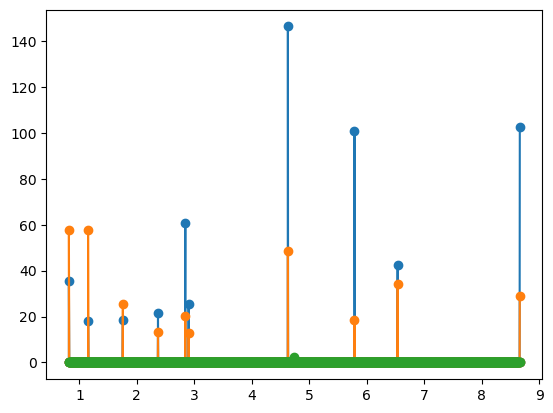

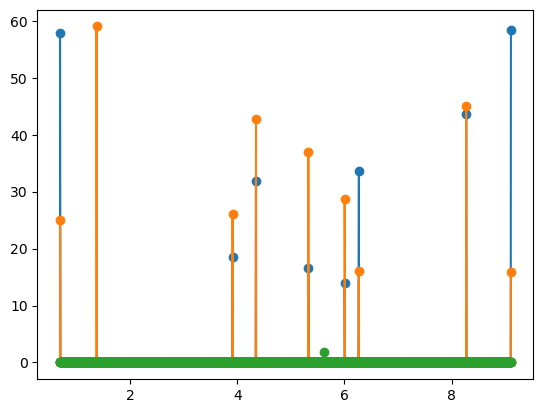

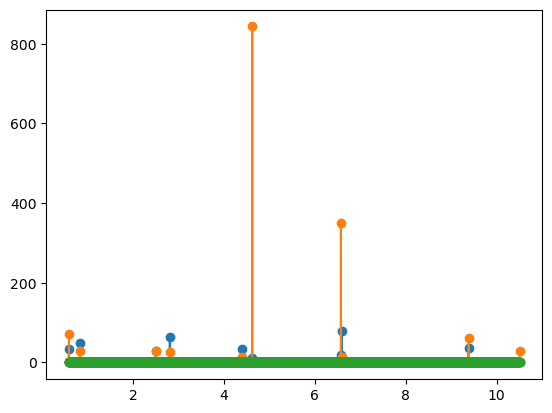

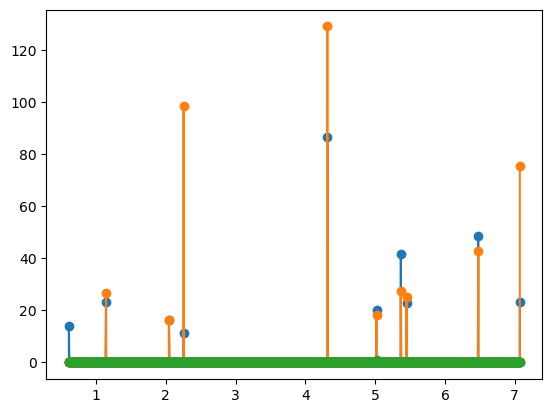

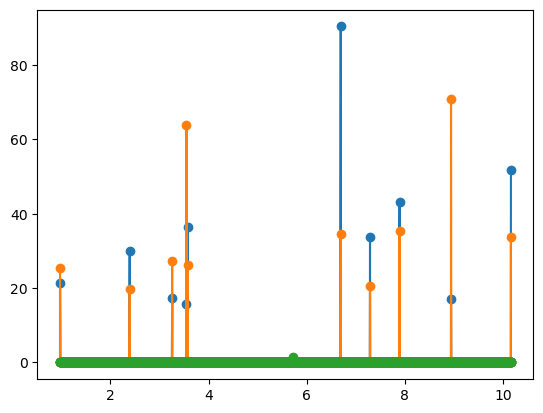

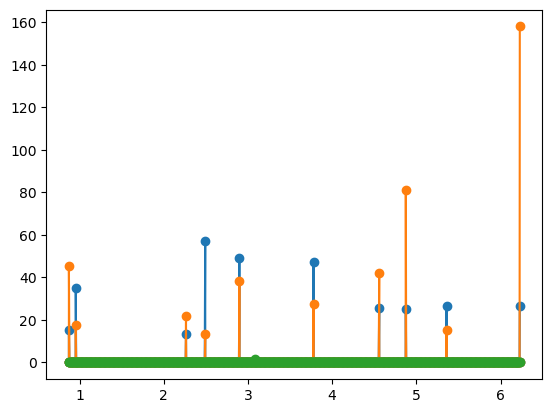

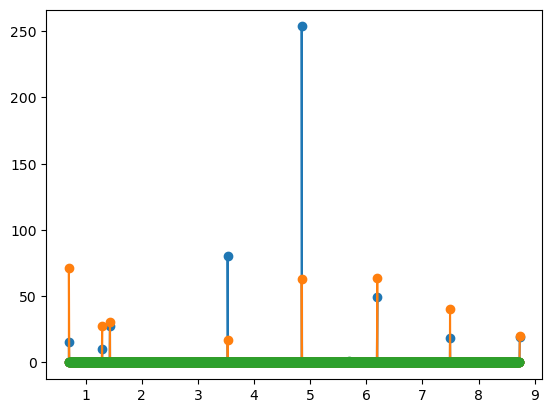

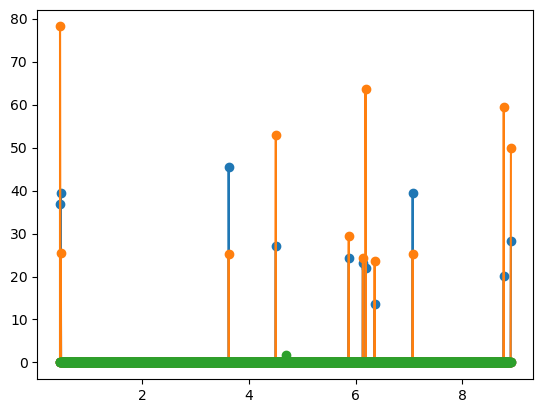

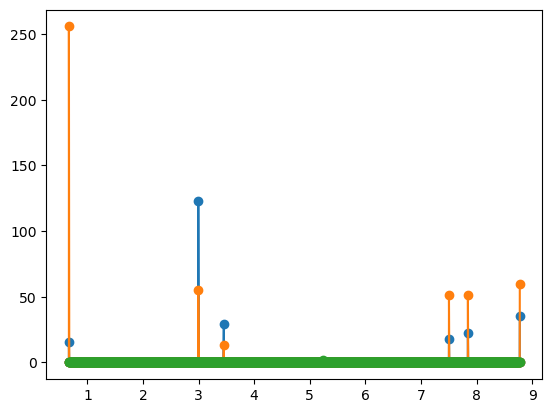

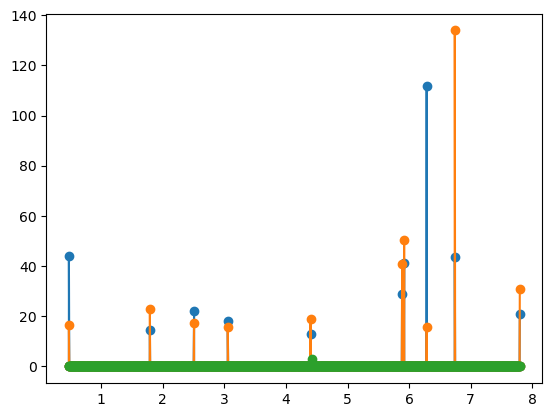

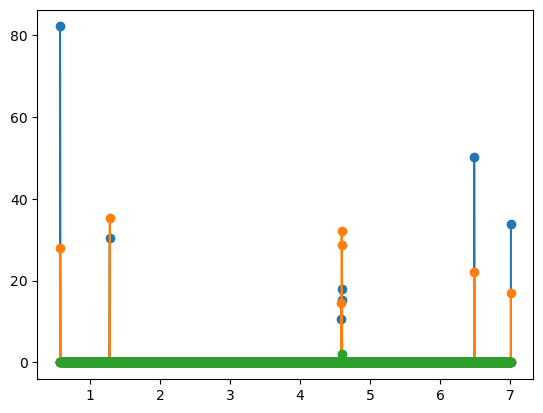

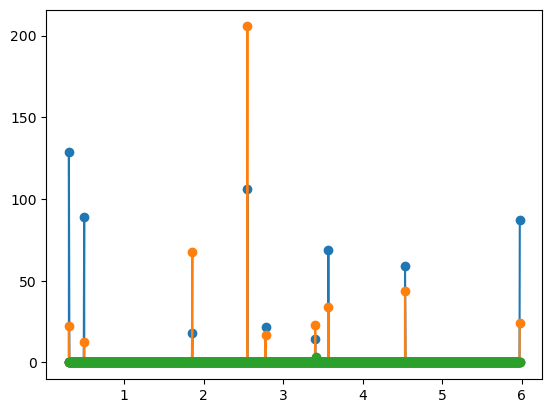

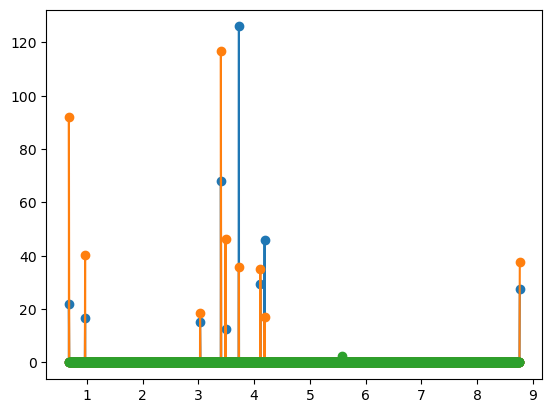

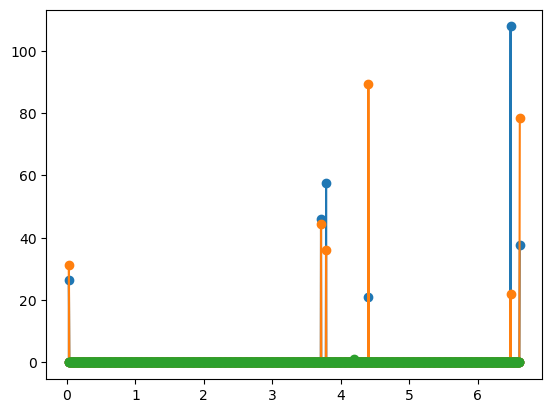

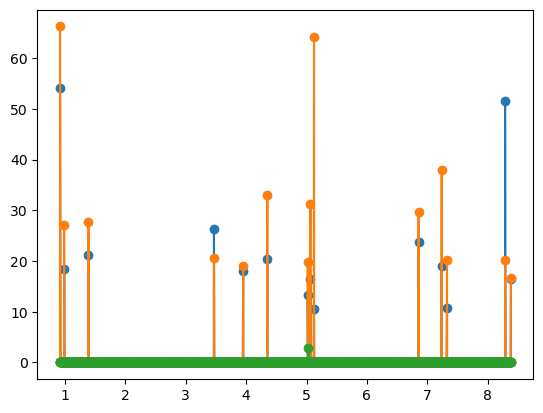

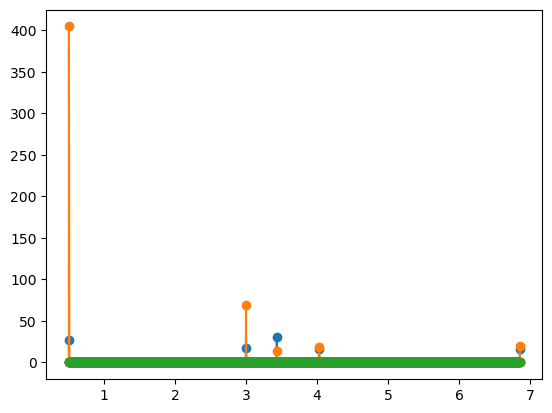

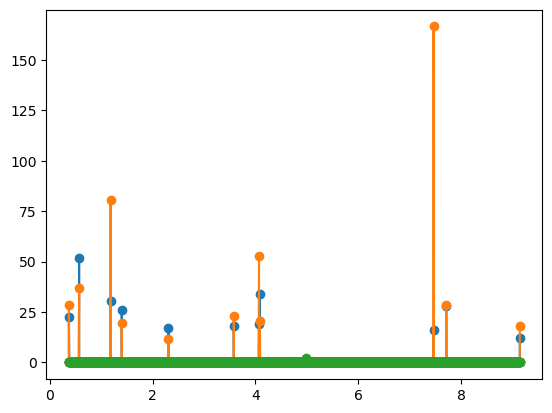

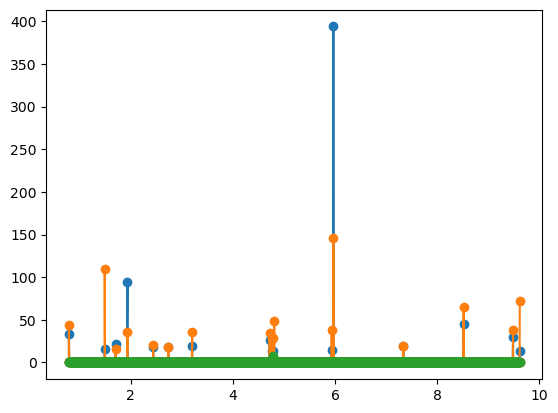

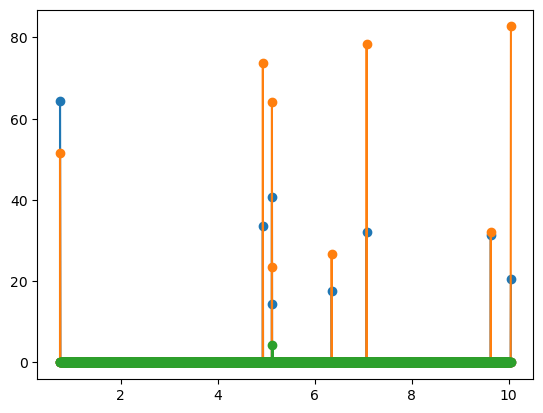

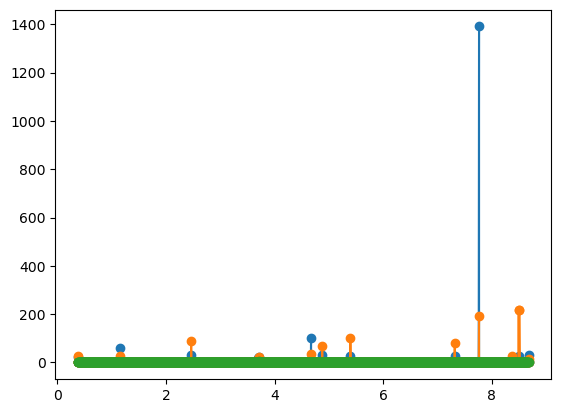

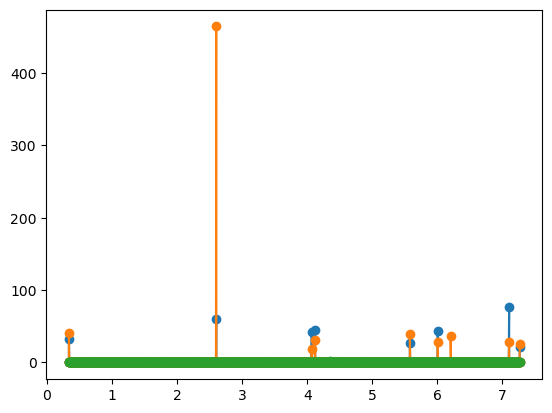

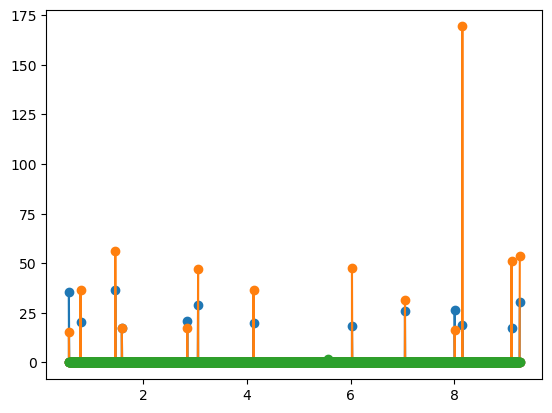

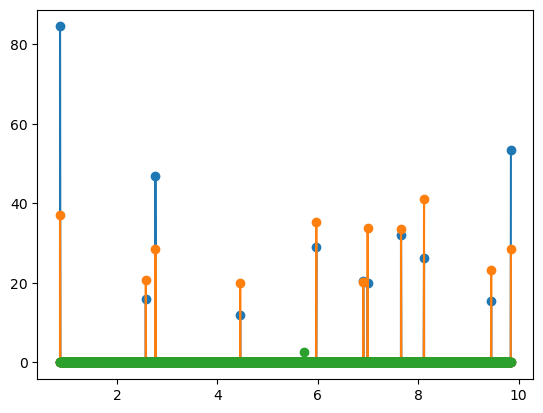

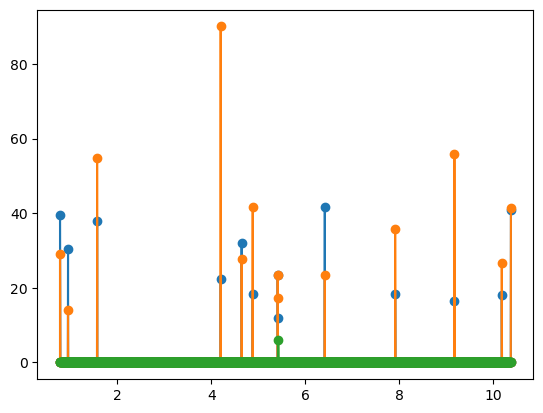

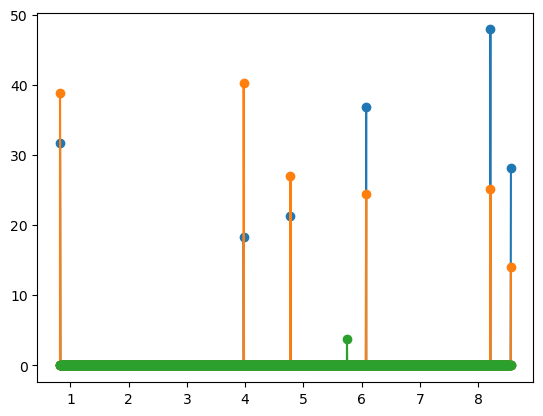

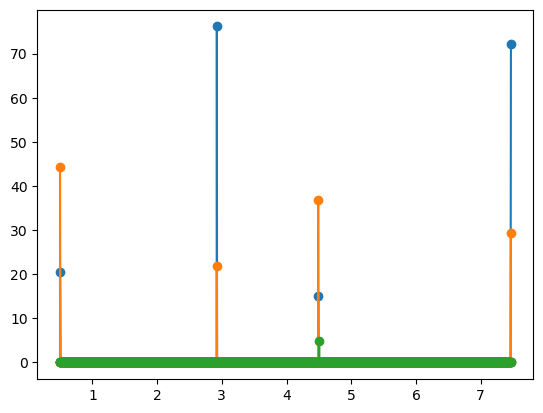

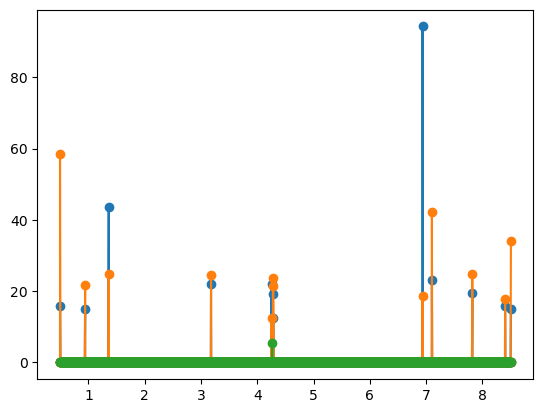

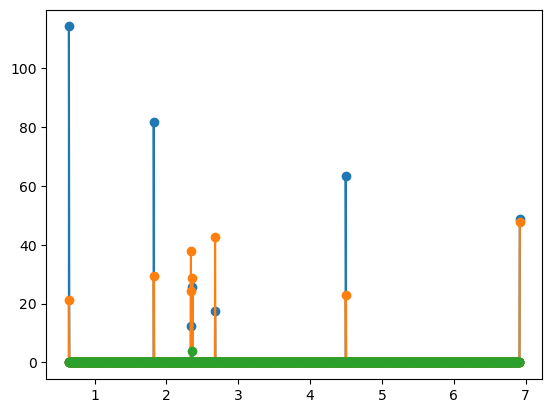

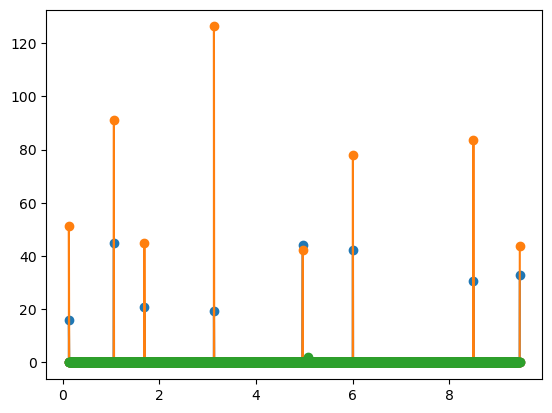

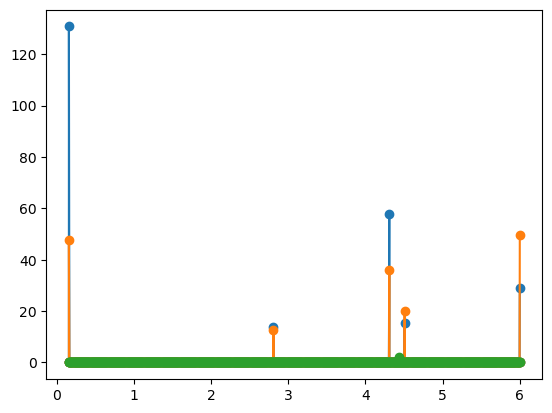

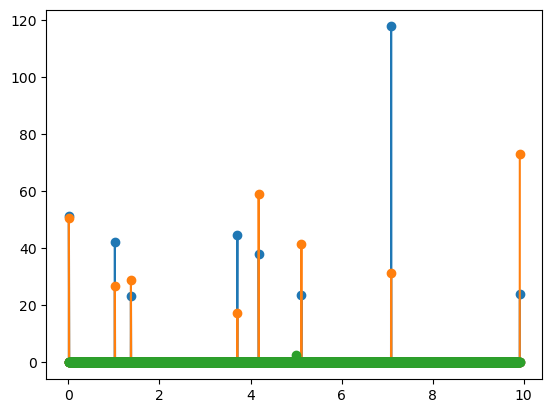

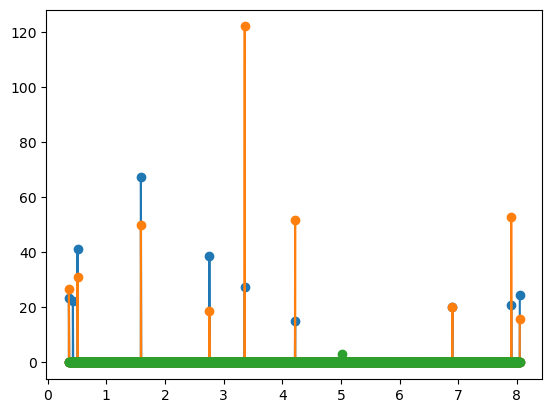

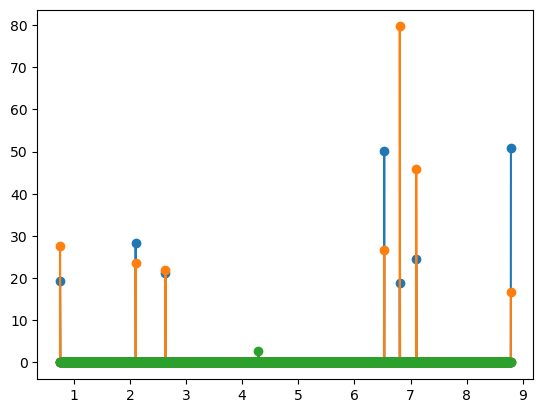

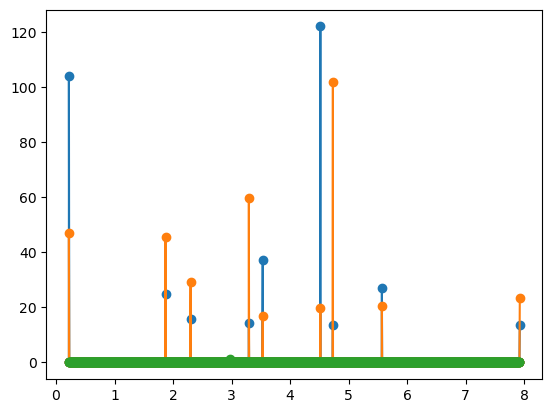

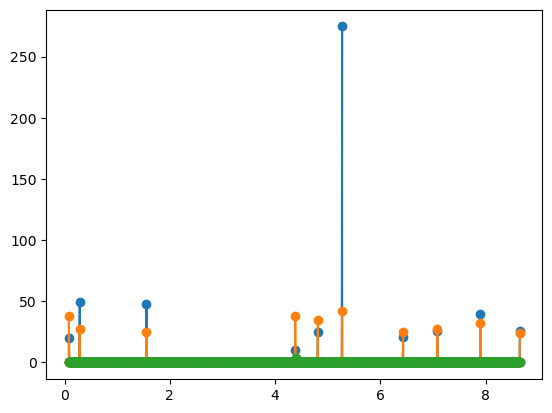

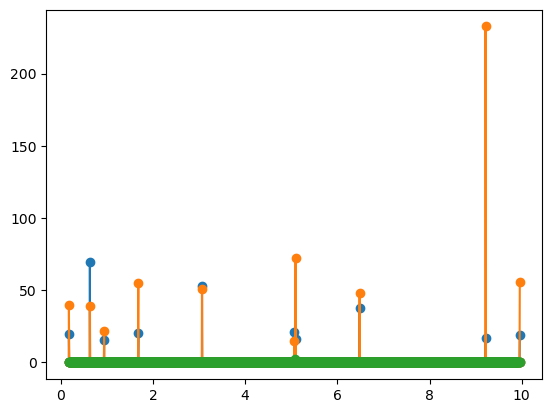

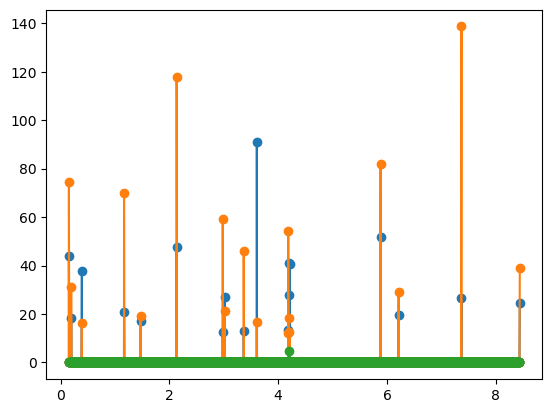

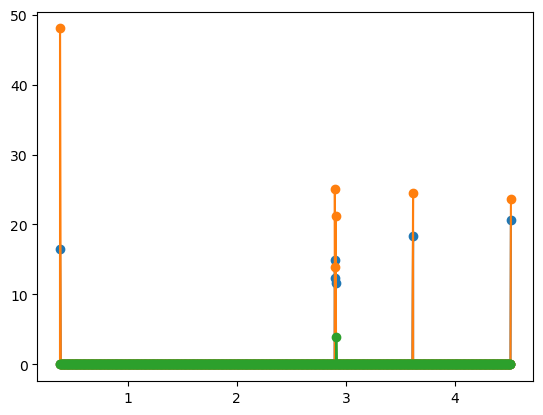

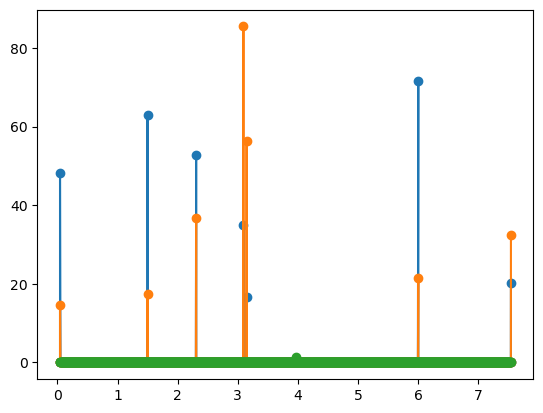

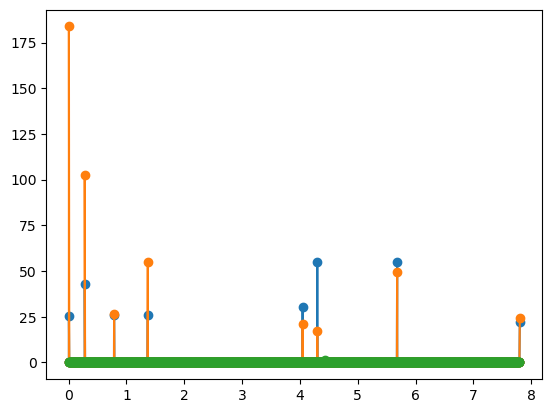

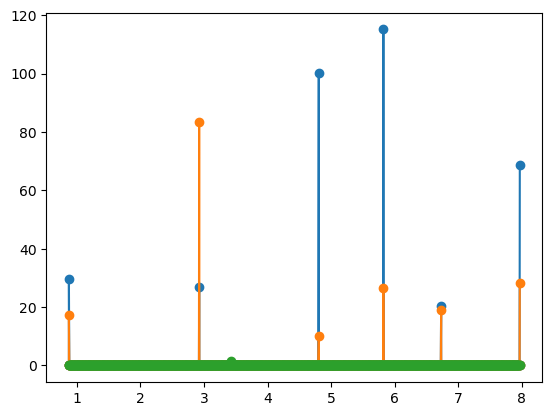

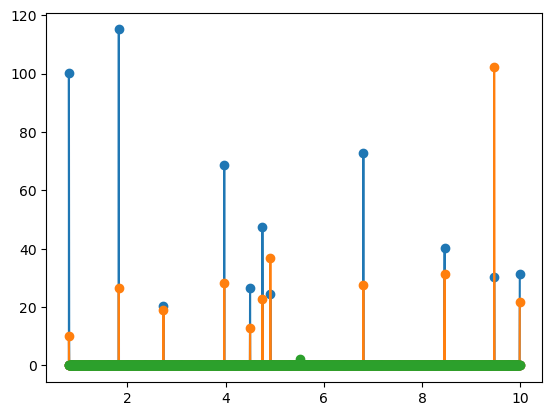

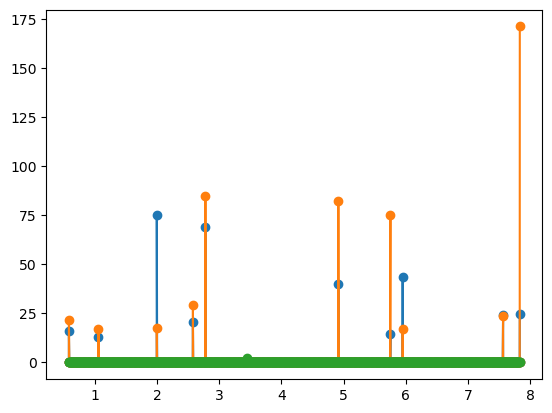

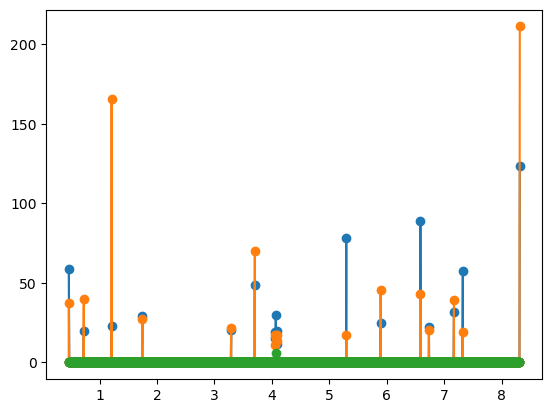

In [53]:
fps = 30 #frames per second
fast_sampling_factor = 5 #sample the amplitude time series this much faster than the frame rate



#choose a single event, for testing
for j in range(len(event_dfs)):
    if(j > 50): break
    ev = event_dfs[j]
    mask = ((ev["ch0 amp"] - ev["ch0 baseline"]) > 10) | ((ev["ch1 amp"] - ev["ch1 baseline"]) > 10)
    pmt_events = ev[mask]
    mask = (np.abs(ev["ch3 charge"]) > 1)
    charge_events = ev[mask]

    #just used to zero the seconds so that we can add nanosecond info
    t0 = np.min([np.min(pmt_events["ch0 seconds"]), np.min(pmt_events["ch1 seconds"]), np.min(charge_events["ch3 seconds"])])

    ch0_ts = []
    ch0_amps = []
    ch1_ts = []
    ch1_amps = []
    ch3_ts = []
    ch3_amps = []

    for i, row in pmt_events.iterrows():
        if(np.isnan(row["ch0 amp"]) == False):
            ch0_ts.append((row["ch0 seconds"] - t0) + row["ch0 nanoseconds"]/1e9)
            #ch0_amps.append(row["ch0 afterpulse integral"] - 8*row["ch0 baseline"])
            ch0_amps.append(row["ch0 amp"] - row["ch0 baseline"])
        if(np.isnan(row["ch1 amp"]) == False):
            ch1_ts.append((row["ch1 seconds"] - t0) + row["ch1 nanoseconds"]/1e9)
            #ch1_amps.append(row["ch1 afterpulse integral"] - 8*row["ch1 baseline"])
            ch1_amps.append(row["ch1 amp"] - row["ch1 baseline"])

    for i, row in charge_events.iterrows():
        if(np.isnan(row["ch3 charge"]) == False):
            ch3_ts.append((row["ch3 seconds"] - t0) + row["ch3 nanoseconds"]/1e9)
            ch3_amps.append(np.abs(row["ch3 charge"]))

    time_bounds = [np.min([np.min(ch0_ts), np.min(ch1_ts), np.min(ch3_ts)]), np.max([np.max(ch0_ts), np.max(ch1_ts), np.max(ch3_ts)])]
    resampled_times = np.arange(time_bounds[0], time_bounds[1], 1.0/fps/fast_sampling_factor)

    ch0_ts = np.concatenate([ch0_ts, resampled_times])
    ch0_amps = np.concatenate([ch0_amps, np.zeros(len(resampled_times))])
    ch1_ts = np.concatenate([ch1_ts, resampled_times])
    ch1_amps = np.concatenate([ch1_amps, np.zeros(len(resampled_times))])
    ch3_ts = np.concatenate([ch3_ts, resampled_times])
    ch3_amps = np.concatenate([ch3_amps, np.zeros(len(resampled_times))])
    #sort all lists simultaneously by their time components
    ch0_ts, ch0_amps = zip(*sorted(zip(ch0_ts, ch0_amps)))
    ch1_ts, ch1_amps = zip(*sorted(zip(ch1_ts, ch1_amps)))
    ch3_ts, ch3_amps = zip(*sorted(zip(ch3_ts, ch3_amps)))

    fig, ax = plt.subplots()
    ax.plot(ch0_ts, ch0_amps, "o-", label="ch0")
    ax.plot(ch1_ts, ch1_amps, "o-", label="ch1")
    ax.plot(ch3_ts, ch3_amps, "o-", label="ch3")
    plt.show()


    

float